# Project 5 - Vehicle detection

---
## Overview

In this project, I developed a model that detects cars from a video stream and draw rectangles around the cars detected by the model.

The labeled data for vehicle and non-vehicle examples to train your classifier is from a combination of the [**GTI vehicle image database**](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [**KITTI vision benchmark suite**](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. This has been provided by udacity

When training the model, a **SVM (Support Vector Machine)** as requested was used.

In this project the following python script is used:
   - **lesson_functions.py**: It contains all necessary functions for the pipeline for detecting vehicles
   
This project has been done with inspiration from this post: https://github.com/wonjunee/udacity-detecting-vehicles

---
## 1 - Creating Features

Features used for the model consist of a spatial binning, a color histogram and HOG (Historgram of Oriented Gradient).
   
#### The Best Set of Parameters  
After repeating belows procedure many times with different sets of parameters, the following set of parameters yielded good results

- Spatial Binning of Color: size = (16, 16)
- Histograms of Color: nbins = 32
- Color Space: YCrCb
- Histogram of Oriented Gradient (HOG): orient = 8, pix_per_cell = 8, cell_per_block = 2

#### Steps performed

- Read in data
- Extract Features
- Normalize Feature vectors with StandardScaler() from sklearn.preprocessing
- Split into training and test set
- Save the data into pickle files

In [6]:
#Perform the necessary imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob
import time
import pickle
from lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [7]:
#Function to read in the data and extract the features as well as safe it to a pickle file

def extract_and_save_features():
    
    #Define the parameters needed
    color_space = 'YCrCb' 
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' 
    spatial_size = (16, 16)
    hist_bins = 32
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    
    parameters = {'color_space': color_space,
                  'orient': orient,
                  'pix_per_cell': pix_per_cell,
                  'cell_per_block': cell_per_block,
                  'hog_channel': hog_channel,
                  'spatial_size': spatial_size,
                  'hist_bins': hist_bins,
                  'spatial_feat': spatial_feat,
                  'hist_feat': hist_feat,
                  'hog_feat': hog_feat}
    
    print("1 - read in the images")
    
    # Arrays for images
    cars = []
    notcars = []

    # Read in images with glob library which lets one read in all the images from a folder
    cars_images = glob.glob('train_images/vehicles/*')
    for folder in cars_images:
        cars += glob.glob('{}/*.png'.format(folder))

    notcars_images = glob.glob('train_images/non-vehicles/*')
    for folder in notcars_images:
        notcars += glob.glob('{}/*.png'.format(folder))

    print("cars size:", len(cars))
    print("notcars size:", len(notcars))
    print("2 - starting to extract the features")
    
    #Extract the features
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    print("3 - normalize the features and split in to test/training data set")

    #Scale the features with the help of standard scaler
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print("4 - save pickle file")

    # Save the data feature data into a pickle file
    pickle_file = 'train_images/features.p'
    if not os.path.isfile(pickle_file):
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'train_dataset': X_train,
                        'train_labels': y_train,
                        'test_dataset': X_test,
                        'test_labels': y_test,
                        'X_scaler': X_scaler,
                        'parameters': parameters
                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise
    
    print("5 - function done")

In [8]:
extract_and_save_features()

1 - read in the images
cars size: 8792
notcars size: 8968
2 - starting to extract the features
3 - normalize the features and split in to test/training data set
4 - save pickle file
5 - function done


#### Features used

##### 1. Spatial Binning of Color

- The first part of the feature is the raw pixel values of an image. The image from training data is resized and converted into a vector using **ravel()**.

*cv2.resize()* function from **OpenCV** library is used to resize the image.

    # Define a function to compute binned color features  
    def bin_spatial(img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
        
##### 2. Histogramms of color

- We can detect a car by looking at its colors. Color of an image provides important information that can help us to distinguish a car from non-car.

**YCrCb** just like any other color spaces contains **3** color channels. Histograms of pixels from each channel are constructed with bin size equals 32.

    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
        
##### 3. Histogramms of object oriented gradients
        
- A car can be distinguished from a non-car by looking at its edges. **HOG** will compute the gradients from blocks of cells. Then, a histogram is constructed with these gradient values.
- A HOG visulation of a car is shown below.

I used **hog** function from **scikit-image**.

    # Define a function to return HOG features and visualization
    def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features

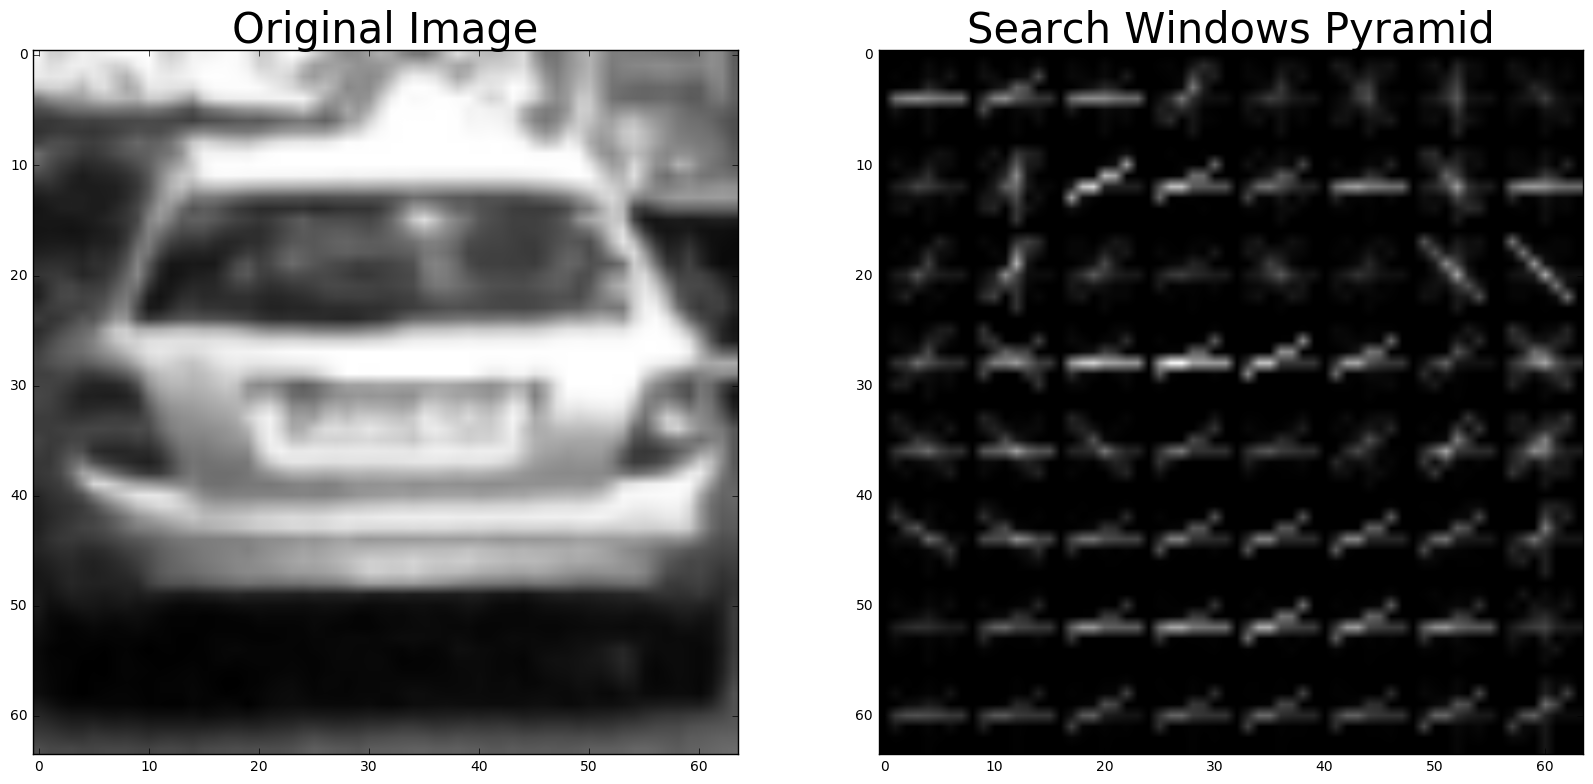

In [12]:
carimage = mpimg.imread('train_images/vehicles/KITTI_extracted/373.png')

carimage = cv2.cvtColor(carimage, cv2.COLOR_RGB2GRAY)

features, hogimage = get_hog_features(carimage, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Visualize hog features
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(carimage, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hogimage, cmap='gray')
ax2.set_title('HOG features describing the image', fontsize=30)

---
## 2 - Constucting A Model

After extracting features from all data, I used as requested a **SVM** as classifier for vehicle/non-vehicle detection

#### Steps performed

- Read in the features that have been produced before as training data
- Train the SVM
- Test the accuracy with the test data set. See below to code for results
- Save the model for later use

In [9]:
#Perform the necessary imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import glob
import time
import pickle
from lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [10]:
def train_and_safe_model():
    
    # Load training data from pickle file
    
    print("1 - load pickled training and test data")
    
    pickle_file = 'train_images/features.p'
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        X_train = pickle_data['train_dataset']
        y_train = pickle_data['train_labels']
        X_test = pickle_data['test_dataset']
        y_test = pickle_data['test_labels']
        X_scaler = pickle_data['X_scaler']
        parameters = pickle_data['parameters']
        del pickle_data  # Free up memory
    
    print("2 - starting training the model")

    # Use a linear SVC and train it
    svc = LinearSVC(max_iter=20000)
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    # Check the accuracy and training time.
    print(round(t2-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    print("4 - save model to pickle file")

    # Save the model for later use
    pickle_file = 'model.p'
    if not os.path.isfile(pickle_file):
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'svc': svc,
                        'X_scaler': X_scaler,
                        'parameters': parameters
                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise
            
    print("5 - model training is done")

In [11]:
train_and_safe_model()

1 - load pickled training and test data
2 - starting training the model
67.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
4 - save model to pickle file
5 - model training is done


---
## 3 - Define the pipeline

The cells below define the pipeline that is going to be used in the project

#### Steps performed

##### 1.Prepare the pipeline
- Import libraries
- Define the sliding windows

##### 2.The actual pipeline
- Normalize the input image
- Perform a sliding window in the range specified under 1
- Predict for each sliding window whether its containing a car / not a car based on the pretrained SVM
- Use all the windows small and large ones that are identified as containing a car in the sliding window and create a heatmap 
- Use the heatmap to combine the windows from the sliding window procedure. So that 1 vehicle only has 1 bounding box left anymore
- Compare the now given canditates for vehicles to the candidates from the last frame. A candidate is considered a vehicle only if an overlapping bounding box has been identified as vehicle in the last frame as well. This should filter outliers


Model and parameters loaded.


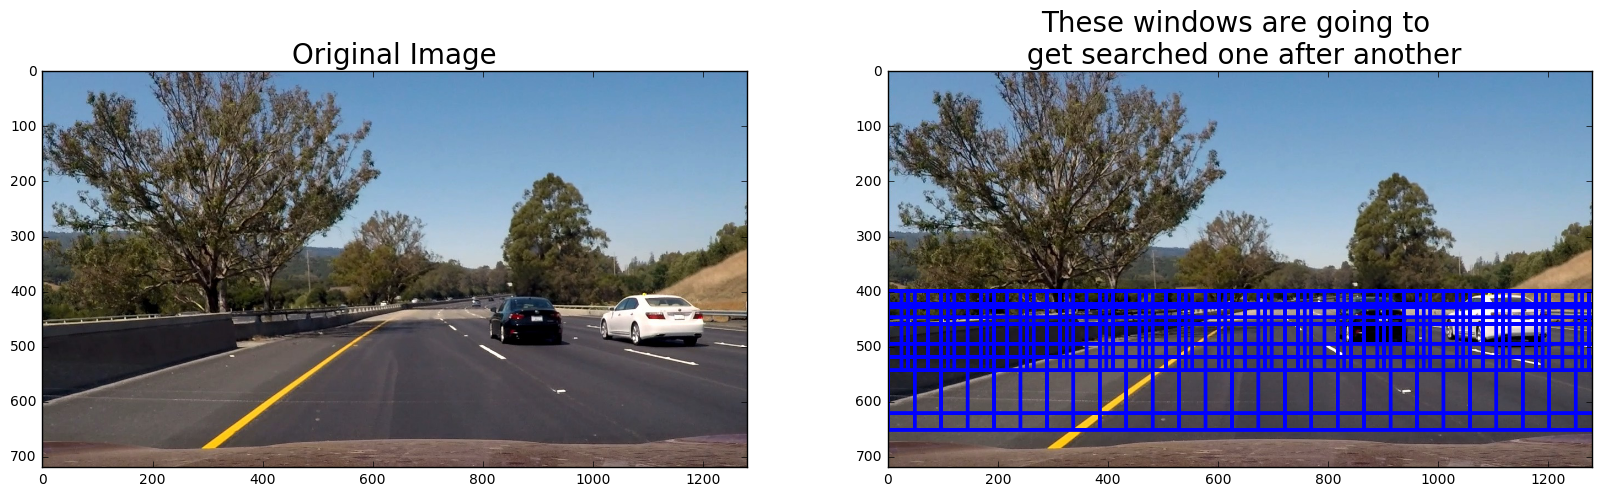

In [4]:
#Perform the necessary imports

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline


# Reload the model and the parameters that have been saved in the pickle file after training
pickle_file = 'model.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    svc = pickle_data['svc']
    X_scaler = pickle_data['X_scaler']
    parameters = pickle_data['parameters']
    del pickle_data  # Free up memory

color_space = parameters['color_space']
orient = parameters['orient']
pix_per_cell = parameters['pix_per_cell']
cell_per_block = parameters['cell_per_block']
hog_channel = parameters['hog_channel']
spatial_size = parameters['spatial_size']
hist_bins = parameters['hist_bins']
spatial_feat = parameters['spatial_feat']
hist_feat = parameters['hist_feat']
hog_feat = parameters['hog_feat']

# Define the ranges for search windows that are then used in the sliding windows procdures
image = mpimg.imread('test_images/test6.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], xy_window=(144, 144), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[430, 550], xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 580], xy_window=(192, 192), xy_overlap=(0.75, 0.75))

print('Model and parameters loaded.')

# Visualize the windows that the sliding windows procedure is going to search one after another
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(draw_boxes(image, windows))
ax2.set_title('These windows are going to \n get searched one after another', fontsize=20)

In [5]:
def pipeline_process_image(image, show_output=0):
    
    global old_boxes
    global set_prev
    
    # Normalize image
    raw_image = image.astype(np.float32)/255
    
    
    #Perform a sliding window in the range specified under 1
    #Predict for each sliding window whether its containing a car / not a car based on the pretrained SVM 
    #Hot windows contains all windows predicted as car
    hot_windows = search_windows(raw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Visualize if show_debug ==1
    if show_output==1:
        f1, (ax1) = plt.subplots(1, 1, figsize=(13,7))
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=10,fontweight='bold',color='red')
        hotbox_image=draw_boxes(image, hot_windows,color=(0, 0, 255), thick=3)
    
    #Use all the windows small and large ones that are identified as containing a car in the sliding window and create a heatmap 
    #Use the heatmap to combine the windows from the sliding window procedure. So that 1 vehicle only has 1 bounding box left anymore
    hot_windows, heatmap = combine_boxes(hot_windows, raw_image.shape)

    #Compare the now given canditates for vehicles to the candidates from the last frame. A candidate is considered a vehicle only if an overlapping bounding box has been identified as vehicle in the last frame as well. This should filter outliers
    #Only working starting from the second frame in the video
    results, old_boxes = average_boxes_new(hot_windows, old_boxes, set_prev)
    
    #In case its the first frame. Set set_prev so that in the next frame average boxes is going to do stuff.
    if set_prev == 0:
        set_prev = 1
    
    # Visualize if show_debug ==1
    if show_output==1:
        f1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,7))
        ax1.imshow(hotbox_image)
        ax1.set_title('Boxes with candidates of cars', fontsize=10,fontweight='bold',color='red')        
        ax2.imshow(heatmap,cmap='gray')
        ax2.set_title('Heatmap', fontsize=10,fontweight='bold',color='red')
        ax3.imshow(draw_boxes(hotbox_image, results,color=(255, 0, 0), thick=3))
        ax3.set_title('Combined and averaged boxes', fontsize=10,fontweight='bold',color='red')
        
    # Return an image with boxes drawn
    return draw_boxes(image, results, color=(0, 0, 255), thick=6)  

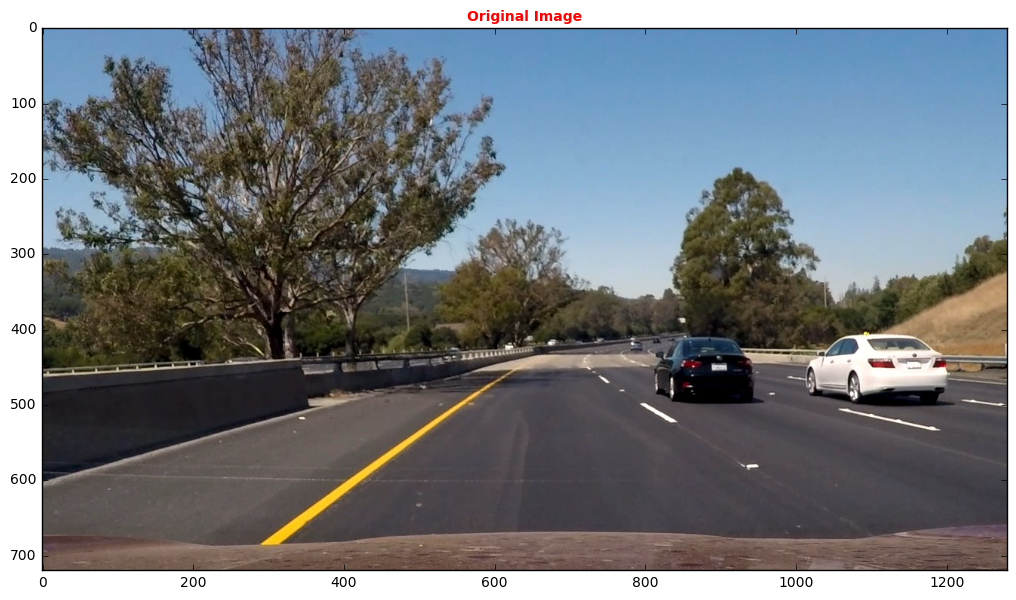

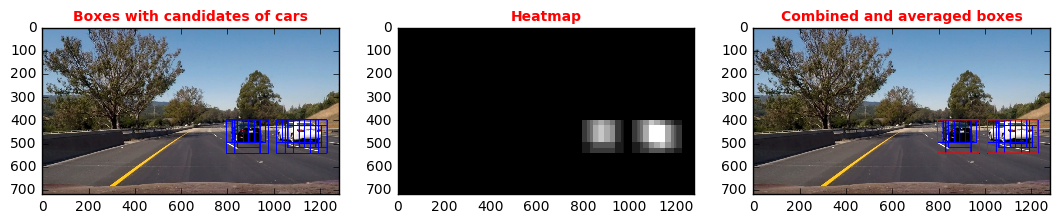

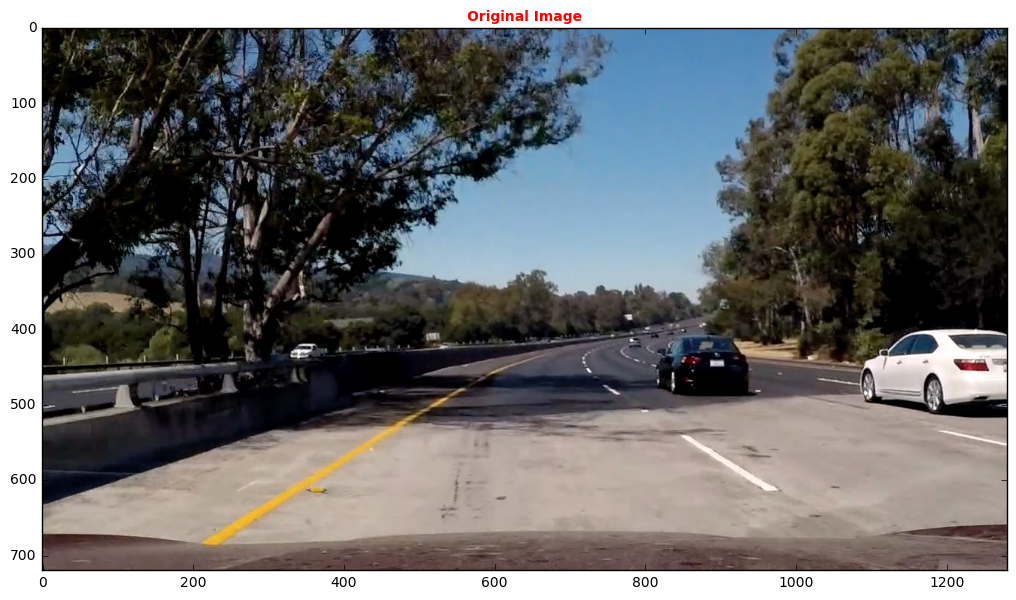

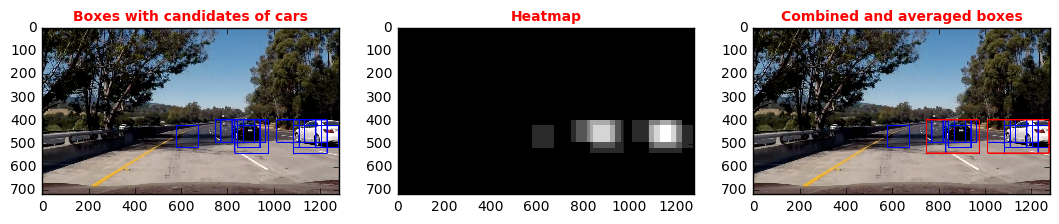

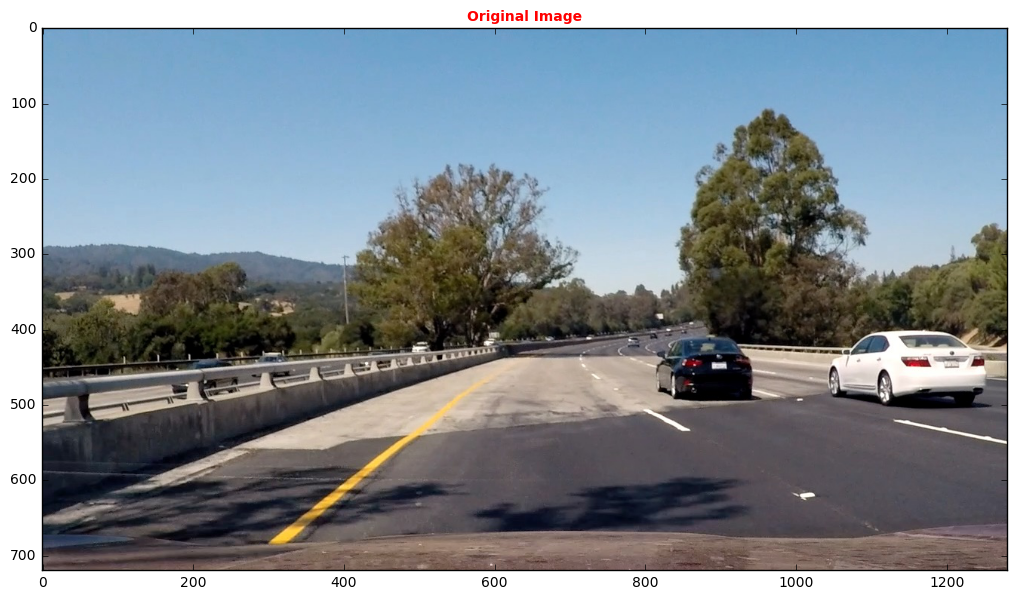

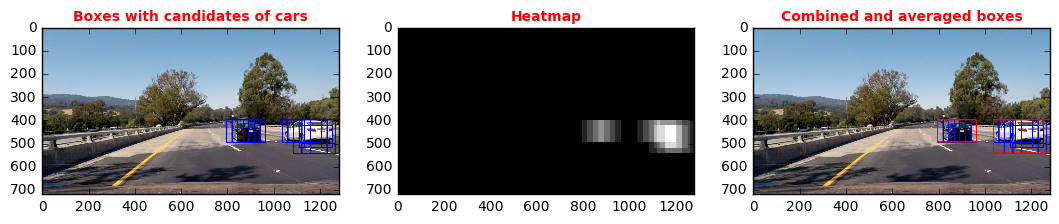

In [6]:
#Test the pipeline
#For explanation. see below the pictures

set_prev = 0
old_boxes=[]

images_array=[mpimg.imread('test_images/test6.jpg'),mpimg.imread('test_images/test5.jpg'),mpimg.imread('test_images/test4.jpg')]

for i in range(0,3):
    result=pipeline_process_image(images_array[i], show_output=1)

#### Pipeline function explained

Above shown is the output of the pipeline that has been called on the testimages 6-4 in order to visualize how its working. One always sees the input image labelled as original image. Afterwards one sees the 3 most important intermediate steps of the pipeline.

- The image "Boxes with candidates of cars" shows all the windows that have been labelled to contain a car. This has been produced by performing the sliding window technique and applying the SVM to predict car / not car on each window. The code used for this from **lesson_functions.py** is:

```python
####Function from the Udacity chapter lesson_functions.py. No changes have been made to this.
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)

    return on_windows
```

- The image "Heatmap" shows an image in which all the bounding box areas with cars have a pixel value > 0 everything else is 0. The code used for this from **lesson_functions.py** is:

```python
# Convert windows to heatmap numpy array.
def create_heatmap(windows, image_shape):
    background = np.zeros(image_shape[:2])
    for window in windows:
        background[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return background
```

- The image "Combined and averaged boxes" shows an image with the outputs of the most important steps. In fact its two steps that are being done here. Both of them can be used for filtering false positives. 

>- At first one uses the heatmap to combine the different windows. The reason one does this, is because the same car is being detected several times in the image as several sliding windows cover the same area. The ndimage label function is used for this. This function labels continously connected areas in the image with one label. Also a threshold is applied. With the threshold one could only consider areas that have been detected at least twice meaning by two different sliding windows. This is to avoid false positivs, I did not do this as I use a different false positivs avoiding method which comes after. The code used for this from **lesson_functions.py** is:

```python
# find the nonzero areas from a heatmap and
# turn them to windows
def find_windows_from_heatmap(image):
    hot_windows = []
    # Threshold the heatmap. Is set to zero. A good value would be also 1 then at least 2 bounding boxes from the sliding window must have been found in order to be a candidate.
    thres = 0
    image[image <= thres] = 0
    # Set labels
    labels = ndi.label(image)
    # iterate through labels and find windows
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        hot_windows.append(bbox)
    return hot_windows

#Function to combine the boxes with the basis of a created heatmap of those boxes.
def combine_boxes(windows, image_shape):
    hot_windows = []
    heatmap = None
    if len(windows)>0:
        # Create heatmap with windows
        heatmap = create_heatmap(windows, image_shape)
        # find boxes from heatmap
        hot_windows = find_windows_from_heatmap(heatmap)
    # Return combined windows.
    return hot_windows,heatmap
```

>- Second one compares the now found combined boxes with the ones found in the previous frame. Only the ones for which an overlapping box in the previous frame has been found are being kept. This shall filter out false positivs that have only been found in one frame but not in the next. The code used for this from **lesson_functions.py** is:


```python
#Function which compares to bounding boxes and returns 0 in case they don't overlap and 1 in case they do overlap
def doOverlap(box1, box2):
  
    l1x, l1y = box1[0]
    r1x, r1y = box1[1]
    l2x, l2y = box2[0]
    r2x, r2y = box2[1]
    
    # If one rectangle is on left side of other rectangles do not overlap return 0
    if (l1x > r2x or l2x > r1x):
        return 0

    # If one rectangle is above other rectangles do not overlap return 0
    elif (l1y > r2y or l2y > r1y):
        return 0

    else:
        return 1

# Compare the new boxes with boxes from previous frames. Only boxes which overlap with an already seen once in the previous frame are being kept.
def average_boxes_new(new_boxes, old_boxes, set_prev):
    
	#In case its the first frame do noting but just return the boxes
	if(set_prev==0):
        return new_boxes, new_boxes
    
	#This branch gets taken when its not the first frame
    else:
        #Array in which the result from the comparision will get saved
        already_seen = np.zeros(len(new_boxes))
        
		#Go ahead and fill already seen vector. Entry 1 is set to 1.0 if an overlapping bounding is found in the array from the last frame
		i=0
        for new_box in new_boxes:
            seen=0
            for old_box in old_boxes:
                seen=seen+doOverlap(new_box, old_box)
            if(seen>0.0):
                already_seen[i]=1.0
            i=i+1
        
		#Go ahead and filter the bounding boxes that have been seen in the previous frame and only give back those as confirmed candidates. 
		#However keep the current hot windows to see whether the not confirmed bounding boxes are visible in the next frame as well.
        confirmed_candidates=list()
        z=0
        for new_box in new_boxes:
            if already_seen[z]==1:
                confirmed_candidates.append(new_box)
            z=z+1
			
        return confirmed_candidates, new_boxes 
```

#### Conclusion

The workings of the false positive detection can be seen very nicely in the pictures above. In the second test image = testimage 5 a false positive bounding box is found in the "Boxes with candidates of cars" and "Heatmap" image. But this box is filtered out in the end result for this image. The reason for this that the function "average_boxes_new" did not find a box overlapping in the previous frame which was test image 6

---
## 4 - Perform pipeline on Video

The cells below call the pipeline on the project video

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

set_prev = 0
old_boxes=[]

#Define the output and read in input
project_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4");

#Apply pipeline and write result
result_clip = clip1.fl_image(pipeline_process_image)
%time result_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [32:41<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 32min 43s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

---
## 5 - Discussion

**Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?**

- ### Robustness

>- The averaging function and combine windows / heatmap function works reasonable well. However additional works could be done here to make it more robust
>- One could increase the threshold parameter for the heatmap / combine windows functions
>- One could start to not only compare the last frame and the current frame but several old frames
>- The car and found objects egomotion could be used to filter out false positivs. One knows how a car moves therefore one would know where they should be in the last frame

- ### Failure

>- The pipeline has been trained for cars only. But what about trucks, motorcycles etc. This can lead to serious problems
>- No pedestrians are in the picture but its not sure how the model behaves if there are any
>- The area is a highway. Its not clear whether the model will perform as well in a city where its more colorful. Could be that a lot of buildings then are identified as cars
>- The lighting conditions are quite good. Its not clear what consequences different lighting conditions will have. Especially day/night